#**Week -4**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [0]:
spark = SparkSession.builder.appName("ETL").getOrCreate()
spark

#**Loading data**

In [0]:
dfAtt = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/attendance.csv", header=True, inferSchema=True)
dfEmp = spark.read.csv(r"dbfs:/Volumes/workspace/default/datasets_fo/employees.csv", header=True, inferSchema=True)
dfTas = spark.read.csv(r"/Volumes/workspace/default/datasets_fo/tasks.csv", header=True, inferSchema=True)

In [0]:
dfAtt.printSchema()

root
 |-- attendanceID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- clockIN: string (nullable = true)
 |-- clockOUT: string (nullable = true)
 |-- isLate: integer (nullable = true)
 |-- isAbscent: integer (nullable = true)



In [0]:
dfEmp.printSchema()

root
 |-- employeeID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- role: string (nullable = true)
 |-- email: string (nullable = true)
 |-- hireDate: date (nullable = true)
 |-- status: string (nullable = true)



In [0]:
dfTas.printSchema()

root
 |-- taskID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- taskName: string (nullable = true)
 |-- taskDate: date (nullable = true)
 |-- tasksCompeleted: integer (nullable = true)



#**Cleaning**
- Unable to drop Null from dfAtt(Attendance) because clockin and clockout abscent data reperesented as Null values

In [0]:
dfEmp = dfEmp.dropna()
dfTas = dfTas.dropna()

#**Combining Data**

In [0]:
dfJoined = dfAtt.join(dfEmp, on="employeeID", how="inner").join(dfTas, on="employeeID", how="inner")


#**Department level metrics**

In [0]:
dfJoined = dfJoined.filter(dfJoined.clockIN != "NULL")

In [0]:
dfJoined = dfJoined.withColumn(
    "hoursWorked",
    F.round(
        F.when(
            F.col("clockIN") != "NULL",
            F.unix_timestamp(F.col("clockOUT"), "dd-MM-yyyy HH:mm") - F.unix_timestamp(F.col("clockIN"), "dd-MM-yyyy HH:mm")
        ).otherwise(0) / 3600,
        2
    )
    ) \
    .withColumn(
        "productivityScore", 
        F.when(F.col("hoursWorked") > 0,(F.round(F.col("tasksCompeleted") / F.col("hoursWorked"), 2))).otherwise(0)
    )

In [0]:
deptMetrics = dfJoined.groupBy("department") \
    .agg(
        F.sum("isLate").alias("LateCount"),
        F.sum("isAbscent").alias("AbscentCount"),
        F.round(F.mean("hoursWorked"), 2).alias("AverageWorkHours"),
        F.round(F.mean("productivityScore"), 2).alias("AverageProductivityScore"),
        F.sum("tasksCompeleted").alias("TotalTasksCompleted")
    )
    
deptMetrics.show()

+-----------+---------+------------+----------------+------------------------+-------------------+
| department|LateCount|AbscentCount|AverageWorkHours|AverageProductivityScore|TotalTasksCompleted|
+-----------+---------+------------+----------------+------------------------+-------------------+
|         HR|       12|          12|            5.38|                    0.04|                 18|
|    Finance|       12|          12|            5.25|                    0.25|                108|
|  Marketing|       18|           6|            6.73|                    0.26|                 90|
|Engineering|       24|           6|            7.35|                    0.48|                300|
+-----------+---------+------------+----------------+------------------------+-------------------+



#**Saving file**

In [0]:
deptMetrics.write.mode("overwrite").csv("dbfs:/Volumes/workspace/default/datasets_fo/deptMetrics.csv")

#**Basic visualization**

<Axes: xlabel='department'>

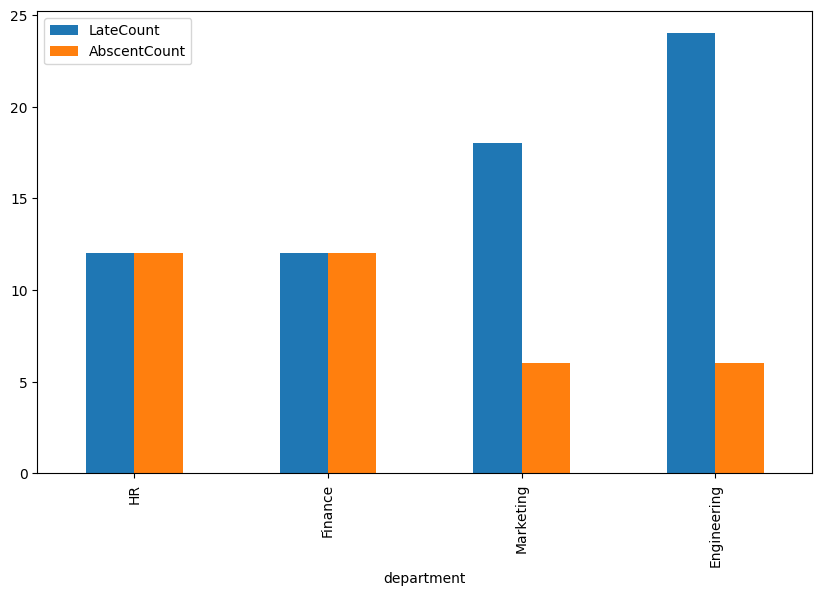

In [0]:
visual = deptMetrics.toPandas()
visual.plot.bar(x="department", y=["LateCount", "AbscentCount"], figsize=(10,6))

<Axes: xlabel='department'>

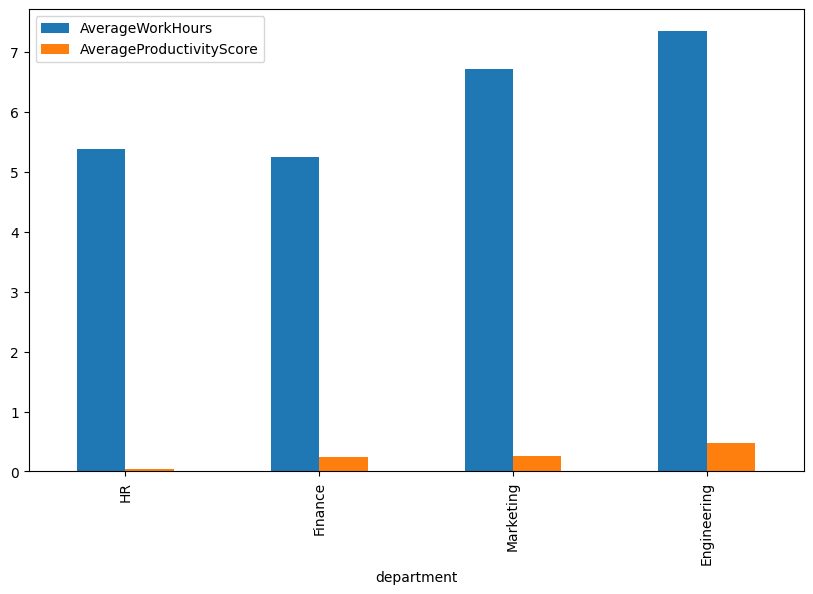

In [0]:
visual.plot.bar(x="department", y=["AverageWorkHours", "AverageProductivityScore"], figsize=(10,6))

<Axes: ylabel='TotalTasksCompleted'>

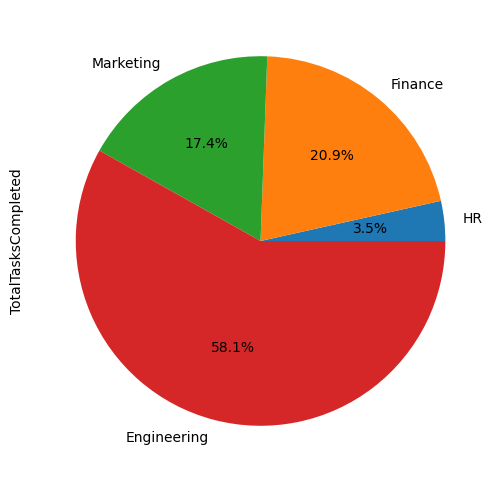

In [0]:
visual.set_index("department")["TotalTasksCompleted"].plot.pie(
    autopct="%1.1f%%", figsize=(10, 6)
)

#**Deliverables**
- ETL databricks notebook
- Exported KPI's

In [0]:
# 1. Full ETL databricks ipynb notbook is attached to git repo under week-4 folder

In [0]:
# 2. Exporting task and attendance KPI's
deptMetrics.select(["department", "LateCount", "AbscentCount", "AverageWorkHours"]).write.mode("overwrite").csv(r"dbfs:/Volumes/workspace/default/datasets_fo/attendanceKPI.csv")
deptMetrics.select(["department", "AverageProductivityScore", "TotalTasksCompleted"]).write.mode("overwrite").csv(r"dbfs:/Volumes/workspace/default/datasets_fo/taskKPI.csv")